In [1]:
# Basic Imports
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.serialization import (
    to_state_dict, msgpack_serialize, from_bytes
)
import optax

# PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

# Import created functions
import make_dataset as mkds
import visualization as vis
from numpy.random import default_rng

prng = jax.random.PRNGKey(0)
rng = default_rng(seed=np.asarray(prng))

2023-03-23 13:25:07.585759: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/22.5/math_libs/11.7/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/Debugger/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/nvvm/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/lib64:/opt/cray/pe/papi/7.0.0.1/lib64:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/libfabric/1.15.2.0/lib64
2023-03-23 13:25:07.585847: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/22.5/math_libs/11.7/lib64:/o

In [2]:
# Get raw MNIST data

train, test = mkds.download_MNIST(download=False)
# Get the training images, convert to numpy, and reshape image array
# to account for channel dim ie. train_data.shape = (N, n_channels, H, W)
train_data = mkds.reshape_with_channel_dim(train.data.numpy())
# Get the labels from the training set
train_labels = train.targets.numpy()

# Do the same as above for the test set
test_data, test_labels = mkds.reshape_with_channel_dim(test.data.numpy()), test.targets.numpy()

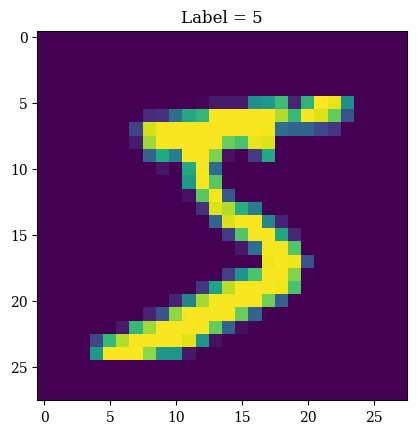

In [3]:
# Plot a sample from the training set
# NOTE: The first index gives us the sample, the 2nd index is 
#       the channel dimension. We index the channel dimension to 
#       allow for plotting of the image.
plt.imshow(train_data[0][0])
plt.title(f'Label = {train_labels[0]}')
plt.show()

# `Perturb Testing` 

Now with our correctly reshaped image data, we can perturb the data, get the empirical field the perturbed data produces, and then save that dataset for training the NN. For clarity, I'll show the perturbing, empirical field calc, and the processing of the data in the cells below:

In [4]:
def vis_perturb_funcs(data,
                      idx_samp,
                      seed=0,                                    
                      sigma=0.9,
                      tau=0.6,
                      M=291,
                      restrict_M=True):
    """
    Visualization of the perturbation functions to see if the two different implementations
    are giving the same results.
    """

    # Set the random seed for the jax and numpy implementation to be the same.
    # This allows for reproducible results between the two implementations.
    prng = jax.random.PRNGKey(seed)
    rng = default_rng(seed=np.asarray(prng))

    # Numpy implementation
    training_perturb = mkds.perturb(samples_batch=train_data, 
                                    rng=rng,
                                    sigma=0.1,
                                    tau=0.03,
                                    M=291,
                                    restrict_M=True)

    # Jax implementation
    jax_training_perturb = mkds.jax_perturb(samples_batch=train_data, 
                prng=prng,
                sigma=0.9,
                tau=0.6,
                M=291,
                restrict_M=True)

    print('Are the JAX & Numpy giving same results for this sample?', 
    np.allclose(jax_training_perturb[idx_samp][:784].reshape(28,28),
    jax_training_perturb[idx_samp][:784].reshape(28,28)))

    print('Are the JAX & Numpy giving same results for all the data?', 
    np.allclose(jax_training_perturb,
    jax_training_perturb))

    fig, ax = plt.subplots(1, 3, figsize=(10,6))
    ax[0].imshow(train_data[idx_samp][0])
    ax[0].set(title='Unperturbed Sample')
    ax[0].axis('off')
    ax[1].imshow(jax_training_perturb[idx_samp][:784].reshape(28,28))
    ax[1].set(title='Numpy Perturbed Sample')
    ax[1].axis('off')
    ax[2].imshow(jax_training_perturb[idx_samp][:784].reshape(28,28))
    ax[2].set(title='Jax Perturbed Sample')
    ax[2].axis('off')
    plt.show()
    

Are the JAX & Numpy giving same results for this sample? True
Are the JAX & Numpy giving same results for all the data? True


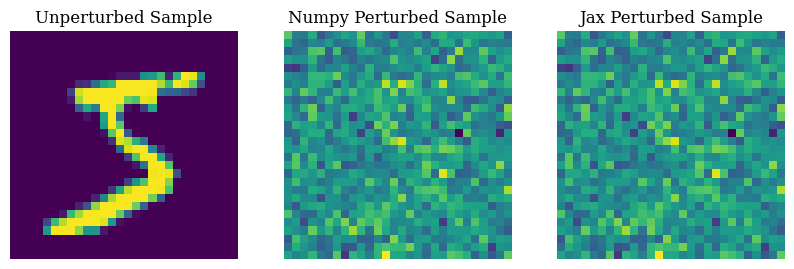

In [20]:
vis_perturb_funcs(train_data,
                  idx_samp=0,
                  sigma=0.01,
                  tau=0.03,
                  M=291,
                  restrict_M=True)

# `Empirical Field Testing`

In [21]:
def empirical_field_grid(batch: np.ndarray,
                         rng: Any,
                         grid_lims: int, 
                         x_coord: int, 
                         y_coord: int,
                         sigma: float,
                         tau: float,
                         M: int,
                        #  sigma=0.001,
                        #  tau=0.01,
                        #  M=291,
                         restrict_M=True):
    """
    Function to be used in visualizations of the empirical field. Due to 
    the MNIST samples being concentrated at the origin once perturbed it's 
    difficult to see what is going on. Hence, we use this function which is
    a modified version of the empirical_field function found in make_dataset.py
    that calculates the empirical field being produced by the MNIST dataset 
    over a uniform grid of points. 

    This uniform grid of points is indexed at the chosen pixel of interest
    which is specified by the (x_coord, y_coord) variables. 

    Args:
    -----
        batch: np.ndarray
            Batch of unperturbed sample data.
        rng: np.random.generator_Generator
            rng used for calculating the perturbing hyperparameters (tau/m,sigma)
        range: int
            Value that sets the limits of the uniform grid of points.
        x_coord: int
            X-coordinate of the pixel of interest
        y_coord: int
            Y-coordinate of the pixel of interest
        
    Returns:
    --------
        target: np.ndarray
            Array containing the empirical field for every pixel (ie. data point).
        perturbed_samples_vec: np.ndarray
            The perturbed input batch with the extra augmented dimension included.
    """
    # This is used to check that a square grid can be constructed from the specified
    # number of samples in the batch. 
    if np.sqrt(len(batch)) % 2 == 0: # check if even
        pass 
    elif np.sqrt(len(batch)) % 1 == 0: # Check if whole number
        pass
    else:
        AssertionError, print('Batchsize is an invalid shape for creating a uniform square grid.')
                        # Valid shapes have the square root of the length of the Batchsize
                        # being either an even number or a whole number     
        
    # Create the values to be used in the grid
    xv = np.linspace(-grid_lims/2, grid_lims/2, int(np.sqrt(len(batch))))
    zv = np.linspace(0, grid_lims, int(np.sqrt(len(batch))))

    x_bar, z_bar = np.meshgrid(xv, zv)
    # Flatten arrays to have the same shape as the rest of the perturbed data
    x_bar = x_bar.flatten()
    z_bar = z_bar.flatten()
    # Translate the two chosen coordinates ie. (x,y) to a 
    # flattened coord that can index the perturbed data array
    chosen_pixel = x_coord * batch.shape[2] + y_coord

    # Create unperturbed batch data vec with an un-augmented extra dimension
    # (i.e. append an extra dimension to the pixel data with the last dimension being 0)
    z = np.zeros(len(batch))

    # z[:, None] to create a 2D array with nothing in the 2nd dim b/c it's about to be concatenated
    unperturbed_samples_vec = np.concatenate((batch.reshape(len(batch), -1), 
                                            z[:, None]), axis=1)

    # Perturb the (augmented) batch data
    perturbed_samples_vec = mkds.perturb(samples_batch=batch,
                                        rng=rng,
                                        sigma=sigma,
                                        tau=tau,
                                        M=M,
                                        restrict_M=True)
    # Update the chosen_pixel to the uniform 1D grid
    perturbed_samples_vec[:, chosen_pixel] = x_bar
    # Update the augmented N+1 dimension to also be a uniform 1D grid
    perturbed_samples_vec[:, -1] = z_bar

    # batch.shape[1/2] = img_size, batch.shape[3] = n_channels
    data_dim = batch.shape[1] * batch.shape[2] * batch.shape[3]

    # Get distance between the unperturbed vector on hyperplane (z=0) and their perturbed versions
    # Expand dims here, so that the 2nd dim of the array doesn't collapse
    # ie. make sure that gt_distance.shape = (batchsize, batchsize), which corresponds to a vector
    # in the N+1 dimension space per sample <-- MAKE THIS CLEARER
    gt_distance = np.sqrt(np.sum((np.expand_dims(perturbed_samples_vec, axis=1) - unperturbed_samples_vec) ** 2,
                                    axis=-1, keepdims=False))

    # For numerical stability, we multiply each row by its minimum value
    # keepdims=True, so we don't lose a dimension
    # Figure out why my code doesn't need a [0] in the numerator of the first distance var
    distance = np.min(gt_distance, axis=1, keepdims=True) / (gt_distance + 1e-7)
    distance = distance ** (data_dim + 1)
    distance = distance[:, :, None]


    # Normalize the coefficients (effectively multiply by c(x_tilde))
    # Expand dims again to avoid losing a dimension
    coeff = distance / (np.sum(distance, axis=1, keepdims=True) + 1e-7)
    diff = - ((np.expand_dims(perturbed_samples_vec, axis=1) - unperturbed_samples_vec))

    # Calculate the empirical Poisson Field (N+1 dimension in the augmented space)
    gt_direction = np.sum(coeff * diff, axis=1, keepdims=False)
    gt_norm = np.linalg.norm(gt_direction, axis=1)
    # Normalize 
    gt_direction /= np.reshape(gt_norm, (-1,1))
    gt_direction *= np.sqrt(data_dim)

    target = gt_direction
    return perturbed_samples_vec, target

def jax_empirical_field_grid(batch: np.ndarray,
                         rng: Any,
                         grid_lims: int, 
                         x_coord: int, 
                         y_coord: int,
                         sigma: float,
                         tau: float,
                         M: int,
                         restrict_M=True):
    """
    Function to be used in visualizations of the empirical field. Due to 
    the MNIST samples being concentrated at the origin once perturbed it's 
    difficult to see what is going on. Hence, we use this function which is
    a modified version of the empirical_field function found in make_dataset.py
    that calculates the empirical field being produced by the MNIST dataset 
    over a uniform grid of points. 

    This uniform grid of points is indexed at the chosen pixel of interest
    which is specified by the (x_coord, y_coord) variables. 

    Args:
    -----
        batch: np.ndarray
            Batch of unperturbed sample data.
        rng: np.random.generator_Generator
            rng used for calculating the perturbing hyperparameters (tau/m,sigma)
        range: int
            Value that sets the limits of the uniform grid of points.
        x_coord: int
            X-coordinate of the pixel of interest
        y_coord: int
            Y-coordinate of the pixel of interest
        
    Returns:
    --------
        target: np.ndarray
            Array containing the empirical field for every pixel (ie. data point).
        perturbed_samples_vec: np.ndarray
            The perturbed input batch with the extra augmented dimension included.
    """
    # This is used to check that a square grid can be constructed from the specified
    # number of samples in the batch. 
    if jnp.sqrt(len(batch)) % 2 == 0: # check if even
        pass 
    elif jnp.sqrt(len(batch)) % 1 == 0: # Check if whole number
        pass
    else:
        AssertionError, print('Batchsize is an invalid shape for creating a uniform square grid.')
                        # Valid shapes have the square root of the length of the Batchsize
                        # being either an even number or a whole number     
        
    # Create the values to be used in the grid
    xv = jnp.linspace(-grid_lims/2, grid_lims/2, int(np.sqrt(len(batch))))
    zv = jnp.linspace(0, grid_lims, int(np.sqrt(len(batch))))

    x_bar, z_bar = jnp.meshgrid(xv, zv)
    # Flatten arrays to have the same shape as the rest of the perturbed data
    x_bar = x_bar.flatten()
    z_bar = z_bar.flatten()
    # Translate the two chosen coordinates ie. (x,y) to a 
    # flattened coord that can index the perturbed data array
    chosen_pixel = x_coord * batch.shape[2] + y_coord

    # Create unperturbed batch data vec with an un-augmented extra dimension
    # (i.e. append an extra dimension to the pixel data with the last dimension being 0)
    z = jnp.zeros(len(batch))

    # z[:, None] to create a 2D array with nothing in the 2nd dim b/c it's about to be concatenated
    unperturbed_samples_vec = jnp.concatenate((batch.reshape(len(batch), -1), 
                                            z[:, None]), axis=1)

    # Perturb the (augmented) batch data
    perturbed_samples_vec = mkds.jax_perturb(samples_batch=batch,
                                        prng=rng,
                                        sigma=sigma,
                                        tau=tau,
                                        M=M,
                                        restrict_M=True)
    # Update the chosen_pixel to the uniform 1D grid
    perturbed_samples_vec[:, chosen_pixel] = x_bar
    # Update the augmented N+1 dimension to also be a uniform 1D grid
    perturbed_samples_vec[:, -1] = z_bar

    # batch.shape[1/2] = img_size, batch.shape[3] = n_channels
    data_dim = batch.shape[1] * batch.shape[2] * batch.shape[3]

    # Get distance between the unperturbed vector on hyperplane (z=0) and their perturbed versions
    # Expand dims here, so that the 2nd dim of the array doesn't collapseß
    # ie. make sure that gt_distance.shape = (batchsize, batchsize), which corresponds to a vector
    # in the N+1 dimension space per sample <-- MAKE THIS CLEARER
    gt_distance = jnp.sqrt(jnp.sum((jnp.expand_dims(perturbed_samples_vec, axis=1) - unperturbed_samples_vec) ** 2,
                                    axis=-1, keepdims=False))

    # For numerical stability, we multiply each row by its minimum value
    # keepdims=True, so we don't lose a dimension
    # Figure out why my code doesn't need a [0] in the numerator of the first distance var
    distance = jnp.min(gt_distance, axis=1, keepdims=True) / (gt_distance + 1e-7)
    distance = distance ** (data_dim + 1)
    distance = distance[:, :, None]


    # Normalize the coefficients (effectively multiply by c(x_tilde))
    # Expand dims again to avoid losing a dimension
    coeff = distance / (jnp.sum(distance, axis=1, keepdims=True) + 1e-7)
    diff = - ((jnp.expand_dims(perturbed_samples_vec, axis=1) - unperturbed_samples_vec))

    # Calculate the empirical Poisson Field (N+1 dimension in the augmented space)
    gt_direction = jnp.sum(coeff * diff, axis=1, keepdims=False)
    gt_norm = jnp.linalg.norm(gt_direction, axis=1)
    # Normalize 
    gt_direction /= jnp.reshape(gt_norm, (-1,1))
    gt_direction *= jnp.sqrt(data_dim)

    target = np.asarray(gt_direction)
    return perturbed_samples_vec, target


In [23]:
def visualize_field_grid(batch: np.ndarray, 
                         sample_idx: int, 
                         x_coord: int, 
                         y_coord: int, 
                         rng: Any,
                         grid_lims: int,
                         sigma,
                         tau,
                         M,
                         restrict_M=True):
    """

    Function that visualizes the empirical Poisson field created by a subset
    of the data distribution (ie. the Poisson field created from the samples
    in the batch) over a uniform grid of points. The visualization takes a 2D
    slice through the N+1 dimensions that PFGM needs to learning the mapping
    input distribution to target distribution.
    
    The chosen dimensions that make up the slice is the z-dimension, which is
    the extra dimension that PFGM needs to add avoid mode collapse and a 
    user specified dimension (ie. pixel) from the target distribution (eg. 
    a pixel in MNIST). With these two dimensions we can see the vector field
    of the empirical Poisson field created by the target distribution.
    
    (INCLUDE A BETTER EXPLANATION) 

    Args:
    -----
        batchsize: int
            Number of samples in batch
        sample_idx: int
            Index of the specified sample found within the batch
        x_coord: int
            X-coordinate of the pixel of interest
        y_coord: int
            Y-coordinate of the pixel of interest
        rng: np.random.generator_.Generator
            rng used for calculating the perturbing hyperparameters

    Returns:
    --------
        A two panel plot with:
            Left plot showing a sample image with a red circle
            overlaid on the chosen pixel who's E field will be
            plotted on the right (quiver) plot.

            Right plot is a quiver plot depicting the E field calculated 
            at the specified pixel value. The x/y coordinates for the points
            in the quiver plot are the (pixel_val, z_value) in the perturbed
            image and the (x/y) coordinates of the arrows are 
            (E_field @ pixel_coord, E_field & z_value)
    """
    vis_batch = batch

    y, E = empirical_field_grid(batch=vis_batch, 
                                rng=rng, 
                                grid_lims=grid_lims, 
                                x_coord=x_coord, 
                                y_coord=y_coord,
                                sigma=sigma,
                                tau=tau,
                                M=M,
                                restrict_M=True)
    
    flat_coord = x_coord * vis_batch.shape[2] + y_coord

    # Get all the samples of the given batch EXCEPT for the element of the sample
    # that is being plotted in the left plot
    everything_except = np.arange(len(y)) != sample_idx

    fig, ax = plt.subplots(1,2, figsize=(10,8))
    ax[0].imshow(vis_batch[sample_idx][0], label='Example of Input image')
    ax[0].scatter(x_coord, y_coord, color='red', s=40, label='Selected pixel')
    ax[0].set(title='Example image of selected input pixel')
    ax[0].axis('off')
    ax[0].legend()
    ax[1].quiver(y[everything_except, flat_coord], y[everything_except,-1],
                 E[everything_except, flat_coord], E[everything_except,-1], label='Poisson Field of other samples');
    # This quiver plot highlights the selected pixel in the left panel. Allowing the audience to see how 
    # this one pixel is mapped into the N+1 dimension above the hyperplane.
    ax[1].quiver(y[sample_idx, flat_coord], y[sample_idx,-1],
                 E[sample_idx, flat_coord], E[sample_idx,-1], color='red', alpha=0.7, label='This pixels Poisson Field');
    ax[1].set_title(f'Poisson field for pixel {x_coord, y_coord}')
    ax[1].set_xlabel(f'Perturbed value of pixel {x_coord, y_coord}')
    ax[1].set_ylabel(f'Z value of pixel {x_coord, y_coord}')
    ax[1].legend()
    plt.show()


def jax_visualize_field_grid(batch: np.ndarray, 
                             sample_idx: int, 
                             x_coord: int, 
                             y_coord: int, 
                             rng: Any,
                             grid_lims: int,
                             sigma,
                             tau,
                             M,
                             restrict_M=True):
    """

    Function that visualizes the empirical Poisson field created by a subset
    of the data distribution (ie. the Poisson field created from the samples
    in the batch) over a uniform grid of points. The visualization takes a 2D
    slice through the N+1 dimensions that PFGM needs to learning the mapping
    input distribution to target distribution.
    
    The chosen dimensions that make up the slice is the z-dimension, which is
    the extra dimension that PFGM needs to add avoid mode collapse and a 
    user specified dimension (ie. pixel) from the target distribution (eg. 
    a pixel in MNIST). With these two dimensions we can see the vector field
    of the empirical Poisson field created by the target distribution.
    
    (INCLUDE A BETTER EXPLANATION) 

    Args:
    -----
        batchsize: int
            Number of samples in batch
        sample_idx: int
            Index of the specified sample found within the batch
        x_coord: int
            X-coordinate of the pixel of interest
        y_coord: int
            Y-coordinate of the pixel of interest
        rng: np.random.generator_.Generator
            rng used for calculating the perturbing hyperparameters
        figure_name: str
            Name of downloaded figure. 
            NOTE: the chosen extension (.png, .jpg, etc.) needs to be included
        figure_dir: str
            Path to the directory where the saved image will be stored.

    Returns:
    --------
        A two panel plot with:
            Left plot showing a sample image with a red circle
            overlaid on the chosen pixel who's E field will be
            plotted on the right (quiver) plot.

            Right plot is a quiver plot depicting the E field calculated 
            at the specified pixel value. The x/y coordinates for the points
            in the quiver plot are the (pixel_val, z_value) in the perturbed
            image and the (x/y) coordinates of the arrows are 
            (E_field @ pixel_coord, E_field & z_value)
    """
    vis_batch = batch

    y, E = jax_empirical_field_grid(batch=vis_batch, 
                                        rng=rng, 
                                        grid_lims=grid_lims, 
                                        x_coord=x_coord, 
                                        y_coord=y_coord,
                                        sigma=sigma,
                                        tau=tau,
                                        M=M,
                                        restrict_M=True)

    flat_coord = x_coord * vis_batch.shape[2] + y_coord

    # Get all the samples of the given batch EXCEPT for the element of the sample
    # that is being plotted in the left plot
    everything_except = np.arange(len(y)) != sample_idx

    fig, ax = plt.subplots(1,2, figsize=(10,8))
    ax[0].imshow(vis_batch[sample_idx][0], label='Example of Input image')
    ax[0].scatter(x_coord, y_coord, color='red', s=40, label='Selected pixel')
    ax[0].set(title='Example image of selected input pixel')
    ax[0].axis('off')
    ax[0].legend()
    ax[1].quiver(y[everything_except, flat_coord], y[everything_except,-1],
                 E[everything_except, flat_coord], E[everything_except,-1], label='Poisson Field of other samples');
    # This quiver plot highlights the selected pixel in the left panel. Allowing the audience to see how 
    # this one pixel is mapped into the N+1 dimension above the hyperplane.
    ax[1].quiver(y[sample_idx, flat_coord], y[sample_idx,-1],
                 E[sample_idx, flat_coord], E[sample_idx,-1], color='red', alpha=0.7, label='This pixels Poisson Field');
    ax[1].set_title(f'Poisson field for pixel {x_coord, y_coord}')
    ax[1].set_xlabel(f'Perturbed value of pixel {x_coord, y_coord}')
    ax[1].set_ylabel(f'Z value of pixel {x_coord, y_coord}')
    ax[1].legend()
    plt.show()

def compare_field_funcs_grid(data,
                             seed,
                             sample_idx=0,
                             x_coord=12,
                             y_coord=8,
                             grid_lims=40,
                             sigma=0.01,
                             tau=0.03,
                             M=291,
                             restrict_M=True):

    # Set the random seed for the jax and numpy implementation to be the same.
    # This allows for reproducible results between the two implementations.
    prng = jax.random.PRNGKey(seed)
    rng = default_rng(seed=np.asarray(prng))


    visualize_field_grid(batch=data, 
                         sample_idx=sample_idx,
                         x_coord=x_coord,
                         y_coord=y_coord,
                         rng=rng,
                         grid_lims=grid_lims,
                         sigma=sigma,
                         tau=tau,
                         M=M,
                         restrict_M=True)


    jax_visualize_field_grid(batch=data, 
                             sample_idx=sample_idx,
                             x_coord=x_coord,
                             y_coord=y_coord,
                             rng=prng,
                             grid_lims=grid_lims,
                             sigma=sigma,
                             tau=tau,
                             M=M,
                             restrict_M=True)

In [30]:
compare_field_funcs_grid(data=perturbed_test_data[:400],
                    seed=0,
                    sample_idx=0)

Batchsize is an invalid shape for creating a uniform square grid.


AttributeError: 'tuple' object has no attribute 'shape'

In [9]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data


class PerturbMNIST(Dataset):
    """
    Simple dataset class that stores the data and targets as NumPy arrays.
    
    Args:
    -----
        data: np.ndarray
            The perturbed input data.
        targets: np.ndarray
            The empirical field that generated the perturbed data.
    """
    def __init__(self, data: np.ndarray, targets: np.ndarray):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.targets)
    
    def __getitem__(self, idx: int):
        """
        Returns the i-th sample and corresponding target in the dataset.
        
        Args:
        -----
            idx: int
                The index of the sample to return.
                
        Returns:
        --------
            tuple: A tuple containing the sample and target.
        """
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target
    
    
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

def create_data_loaders(*datasets : Sequence[data.Dataset],
                        train : Union[bool, Sequence[bool]] = True,
                        batch_size : int = 128,
                        num_workers : int = 4,
                        seed : int = 42):
    """
    Creates data loaders used in JAX for a set of datasets.

    Args:
      datasets: Datasets for which data loaders are created.
      train: Sequence indicating which datasets are used for
        training and which not. If single bool, the same value
        is used for all datasets.
      batch_size: Batch size to use in the data loaders.
      num_workers: Number of workers for each dataset.
      seed: Seed to initialize the workers and shuffling with.
    """
    loaders = []
    if not isinstance(train, (list, tuple)):
        train = [train for _ in datasets]
    for dataset, is_train in zip(datasets, train):
        loader = data.DataLoader(dataset,
                                 batch_size=batch_size,
                                 shuffle=is_train,
                                 drop_last=is_train,
                                 collate_fn=numpy_collate,
                                 num_workers=num_workers,
                                 persistent_workers=is_train,
                                 generator=torch.Generator().manual_seed(seed))
        loaders.append(loader)
    return loaders

In [10]:
perturbed_training = mkds.load_data(data_dir='saved_data/MNIST/perturbed/partitioned',
                                     data_file='partitioned_training_set.pkl')

perturbed_val = mkds.load_data(data_dir='saved_data/MNIST/perturbed/partitioned',
                                     data_file='partitioned_val_set.pkl')

perturbed_test = mkds.load_data(data_dir='saved_data/MNIST/perturbed/partitioned',
                                     data_file='partitioned_test_set.pkl')



training = PerturbMNIST(perturbed_training[0], perturbed_training[1])
val = PerturbMNIST(perturbed_val[0], perturbed_val[1])
testing = PerturbMNIST(perturbed_test[0], perturbed_test[1])

train_dl, val_dl, test_dl = create_data_loaders(training, val, testing,
                                                train=[True, False, False],
                                                batch_size=400)


In [19]:
batch = next(iter(test_dl))
data = batch[0]
data.shape

(400, 785)

In [13]:
def jax_empirical_field_grid(batch: np.ndarray,
                         rng: Any,
                         grid_lims: int, 
                         x_coord: int, 
                         y_coord: int,
                         sigma: float,
                         tau: float,
                         M: int,
                         restrict_M=True):
    """
    Function to be used in visualizations of the empirical field. Due to 
    the MNIST samples being concentrated at the origin once perturbed it's 
    difficult to see what is going on. Hence, we use this function which is
    a modified version of the empirical_field function found in make_dataset.py
    that calculates the empirical field being produced by the MNIST dataset 
    over a uniform grid of points. 

    This uniform grid of points is indexed at the chosen pixel of interest
    which is specified by the (x_coord, y_coord) variables. 

    Args:
    -----
        batch: np.ndarray
            Batch of unperturbed sample data.
        rng: np.random.generator_Generator
            rng used for calculating the perturbing hyperparameters (tau/m,sigma)
        range: int
            Value that sets the limits of the uniform grid of points.
        x_coord: int
            X-coordinate of the pixel of interest
        y_coord: int
            Y-coordinate of the pixel of interest
        
    Returns:
    --------
        target: np.ndarray
            Array containing the empirical field for every pixel (ie. data point).
        perturbed_samples_vec: np.ndarray
            The perturbed input batch with the extra augmented dimension included.
    """
    # This is used to check that a square grid can be constructed from the specified
    # number of samples in the batch. 
    if jnp.sqrt(len(batch)) % 2 == 0: # check if even
        pass 
    elif jnp.sqrt(len(batch)) % 1 == 0: # Check if whole number
        pass
    else:
        AssertionError, print('Batchsize is an invalid shape for creating a uniform square grid.')
                        # Valid shapes have the square root of the length of the Batchsize
                        # being either an even number or a whole number     
        
    # Create the values to be used in the grid
    xv = jnp.linspace(-grid_lims/2, grid_lims/2, int(np.sqrt(len(batch))))
    zv = jnp.linspace(0, grid_lims, int(np.sqrt(len(batch))))

    x_bar, z_bar = jnp.meshgrid(xv, zv)
    # Flatten arrays to have the same shape as the rest of the perturbed data
    x_bar = x_bar.flatten()
    z_bar = z_bar.flatten()

    # Create unperturbed batch data vec with an un-augmented extra dimension
    # (i.e. append an extra dimension to the pixel data with the last dimension being 0)
    z = jnp.zeros(len(batch))

    # z[:, None] to create a 2D array with nothing in the 2nd dim b/c it's about to be concatenated
    unperturbed_samples_vec = jnp.concatenate((batch.reshape(len(batch), -1), 
                                            z[:, None]), axis=1)

    # # Perturb the (augmented) batch data
    # perturbed_samples_vec = mkds.jax_perturb(samples_batch=batch,
    #                                     prng=rng,
    #                                     sigma=sigma,
    #                                     tau=tau,
    #                                     M=M,
    #                                     restrict_M=True)
    # Update the chosen_pixel to the uniform 1D grid
    perturbed_samples_vec[:, chosen_pixel] = x_bar
    # Update the augmented N+1 dimension to also be a uniform 1D grid
    perturbed_samples_vec[:, -1] = z_bar

    # batch.shape[1/2] = img_size, batch.shape[3] = n_channels
    data_dim = batch.shape[1] * batch.shape[2] * batch.shape[3]

    # Get distance between the unperturbed vector on hyperplane (z=0) and their perturbed versions
    # Expand dims here, so that the 2nd dim of the array doesn't collapseß
    # ie. make sure that gt_distance.shape = (batchsize, batchsize), which corresponds to a vector
    # in the N+1 dimension space per sample <-- MAKE THIS CLEARER
    gt_distance = jnp.sqrt(jnp.sum((jnp.expand_dims(perturbed_samples_vec, axis=1) - unperturbed_samples_vec) ** 2,
                                    axis=-1, keepdims=False))

    # For numerical stability, we multiply each row by its minimum value
    # keepdims=True, so we don't lose a dimension
    # Figure out why my code doesn't need a [0] in the numerator of the first distance var
    distance = jnp.min(gt_distance, axis=1, keepdims=True) / (gt_distance + 1e-7)
    distance = distance ** (data_dim + 1)
    distance = distance[:, :, None]


    # Normalize the coefficients (effectively multiply by c(x_tilde))
    # Expand dims again to avoid losing a dimension
    coeff = distance / (jnp.sum(distance, axis=1, keepdims=True) + 1e-7)
    diff = - ((jnp.expand_dims(perturbed_samples_vec, axis=1) - unperturbed_samples_vec))

    # Calculate the empirical Poisson Field (N+1 dimension in the augmented space)
    gt_direction = jnp.sum(coeff * diff, axis=1, keepdims=False)
    gt_norm = jnp.linalg.norm(gt_direction, axis=1)
    # Normalize 
    gt_direction /= jnp.reshape(gt_norm, (-1,1))
    gt_direction *= jnp.sqrt(data_dim)

    target = np.asarray(gt_direction)
    return perturbed_samples_vec, target


# Testing the pre-perturbed data

In [31]:
train_ds, test_ds = mkds.download_MNIST()
test_data, test_labels = test_ds.data.numpy(), test_ds.targets.numpy()
test_data = mkds.reshape_with_channel_dim(test_data)
perturbed_test_data = mkds.process_perturbed_data(test_data, jax.random.PRNGKey(7))

In [33]:
data, targets = perturbed_test_data

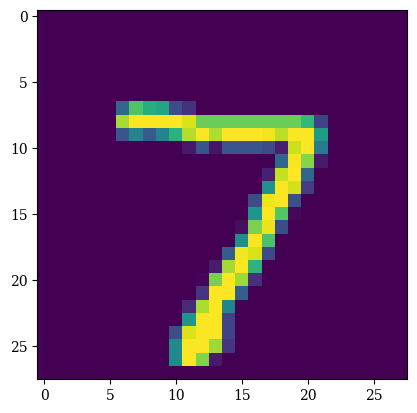

In [49]:
plt.imshow(test_data[0][0])

In [46]:
def jax_visualize_field_grid(batchsize: int, 
                         sample_idx: int, 
                         x_coord: int, 
                         y_coord: int, 
                         grid_lims: int):
    """
    Function that visualizes the empirical Poisson field created by a subset
    of the data distribution (ie. the Poisson field created from the samples
    in the batch) over a uniform grid of points. The visualization takes a 2D
    slice through the N+1 dimensions that PFGM needs to learning the mapping
    input distribution to target distribution.
    
    The chosen dimensions that make up the slice is the z-dimension, which is
    the extra dimension that PFGM needs to add avoid mode collapse and a 
    user specified dimension (ie. pixel) from the target distribution (eg. 
    a pixel in MNIST). With these two dimensions we can see the vector field
    of the empirical Poisson field created by the target distribution.
    
    (INCLUDE A BETTER EXPLANATION) 

    Args:
    -----
        batchsize: int
            Number of samples in batch
        sample_idx: int
            Index of the specified sample found within the batch
        x_coord: int
            X-coordinate of the pixel of interest
        y_coord: int
            Y-coordinate of the pixel of interest
        rng: np.random.generator_.Generator
            rng used for calculating the perturbing hyperparameters
        figure_name: str
            Name of downloaded figure. 
            NOTE: the chosen extension (.png, .jpg, etc.) needs to be included
        figure_dir: str
            Path to the directory where the saved image will be stored.

    Returns:
    --------
        A two panel plot with:
            Left plot showing a sample image with a red circle
            overlaid on the chosen pixel who's E field will be
            plotted on the right (quiver) plot.

            Right plot is a quiver plot depicting the E field calculated 
            at the specified pixel value. The x/y coordinates for the points
            in the quiver plot are the (pixel_val, z_value) in the perturbed
            image and the (x/y) coordinates of the arrows are 
            (E_field @ pixel_coord, E_field & z_value)
    """
    # Create a DL with a user specified batchsize
    data, targets = perturbed_test_data[:batchsize]
    # Assign the images to a specific variable that we'll use for training
    vis_batch = data
    
    flat_coord = x_coord * 28 + y_coord

    # Get all the samples of the given batch EXCEPT for the element of the sample
    # that is being plotted in the left plot
    everything_except = np.arange(len(data)) != sample_idx

    fig, ax = plt.subplots(1,2, figsize=(10,8))
    ax[0].imshow(vis_batch[sample_idx][:-1].reshape((28,28)), label='Example of Input image')
    ax[0].scatter(x_coord, y_coord, color='red', s=40, label='Selected pixel')
    ax[0].set(title='Example image of selected input pixel')
    ax[0].axis('off')
    ax[0].legend()
    ax[1].quiver(data[everything_except, flat_coord], data[everything_except,-1],
                 targets[everything_except, flat_coord], targets[everything_except,-1], label='Poisson Field of other samples');
    # This quiver plot highlights the selected pixel in the left panel. Allowing the audience to see how 
    # this one pixel is mapped into the N+1 dimension above the hyperplane.
    ax[1].quiver(data[sample_idx, flat_coord], data[sample_idx,-1],
                 targets[sample_idx, flat_coord], targets[sample_idx,-1], color='red', alpha=0.7, label='This pixels Poisson Field');
    ax[1].set_title(f'Poisson field for pixel {x_coord, y_coord}')
    ax[1].set_xlabel(f'Perturbed value of pixel {x_coord, y_coord}')
    ax[1].set_ylabel(f'Z value of pixel {x_coord, y_coord}')
    ax[1].legend()
    ax[1].set_xlim(-0.5,0.5)
    ax[1].set_ylim(0,0.5)
    plt.show()

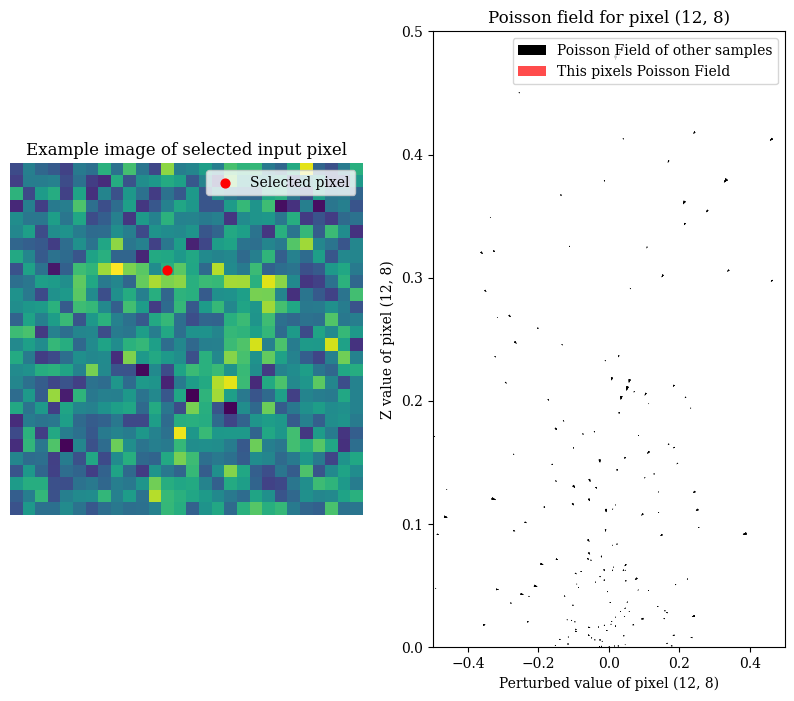

In [47]:
jax_visualize_field_grid(batchsize=400, 
                         sample_idx=0, 
                         x_coord=12, 
                         y_coord=8, 
                         grid_lims=40)